# 🔍 Template Matching – Classical Computer Vision (Non-ML)
**Assignment Mini-Project | OpenCV + NumPy + Matplotlib**

This notebook walks through a complete template matching pipeline step by step:

| Step | What happens |
|------|--------------|
| 0 | Build demo scene + template |
| 1 | Grayscale conversion |
| 2 | `cv2.matchTemplate()` → response map |
| 3 | Threshold + Non-Maximum Suppression (NMS) |
| 4 | Draw detections on original colour image |

## 📦 Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'DejaVu Sans'

print(f'OpenCV version : {cv2.__version__}')
print(f'NumPy  version : {np.__version__}')

OpenCV version : 4.13.0
NumPy  version : 2.4.2


---
## 🎨 Step 0 — Build Demo Images
We create a synthetic **640×480 tabletop scene** containing:
- 🟡 **3 gold coins** (the target objects)
- ⚪ **2 silver coins** (distractors)

The **template** is a clean, noise-free gold coin.

In [2]:
def make_coin(size, color, angle=0):
    """Draw a circular coin patch with a specular highlight."""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    cx, cy, r = size // 2, size // 2, size // 2 - 2
    cv2.circle(img, (cx, cy), r, color, -1)
    # highlight
    highlight = tuple(min(255, c + 70) for c in color)
    cv2.circle(img, (cx - r // 4, cy - r // 4), r // 3, highlight, -1)
    # edge
    cv2.circle(img, (cx, cy), r, (25, 25, 25), 1)
    if angle:
        M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
        img = cv2.warpAffine(img, M, (size, size))
    return img


def build_scene(seed=7):
    np.random.seed(seed)
    H, W = 480, 640
    # textured background
    scene = np.random.randint(120, 160, (H, W, 3), dtype=np.uint8)
    for _ in range(120):
        y   = np.random.randint(0, H)
        col = int(np.random.randint(85, 155))
        cv2.line(scene, (0, y), (W, y + np.random.randint(-10, 10)),
                 (col, col, col), 1)

    COIN = 52
    GOLD, SILVER = (30, 130, 200), (190, 190, 190)

    gold_centres   = [(90, 100), (310, 210), (520, 360)]
    silver_centres = [(210, 330), (440, 110)]

    for (cx, cy) in gold_centres:
        patch = make_coin(COIN, GOLD, angle=int(np.random.randint(0, 25)))
        x0, y0 = cx - COIN//2, cy - COIN//2
        mask = patch.any(axis=2)
        scene[y0:y0+COIN, x0:x0+COIN][mask] = patch[mask]

    for (cx, cy) in silver_centres:
        patch = make_coin(COIN, SILVER, angle=int(np.random.randint(0, 25)))
        x0, y0 = cx - COIN//2, cy - COIN//2
        mask = patch.any(axis=2)
        scene[y0:y0+COIN, x0:x0+COIN][mask] = patch[mask]

    template = make_coin(COIN, GOLD)  # clean reference
    return scene, template, gold_centres, COIN


scene, template, gold_centres, COIN_SZ = build_scene()
print(f'Scene size    : {scene.shape}')
print(f'Template size : {template.shape}')
print(f'Gold coins at : {gold_centres}')

Scene size    : (480, 640, 3)
Template size : (52, 52, 3)
Gold coins at : [(90, 100), (310, 210), (520, 360)]


C:\Users\mohya\AppData\Local\Temp\ipykernel_59140\2850680093.py:22: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mohya\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


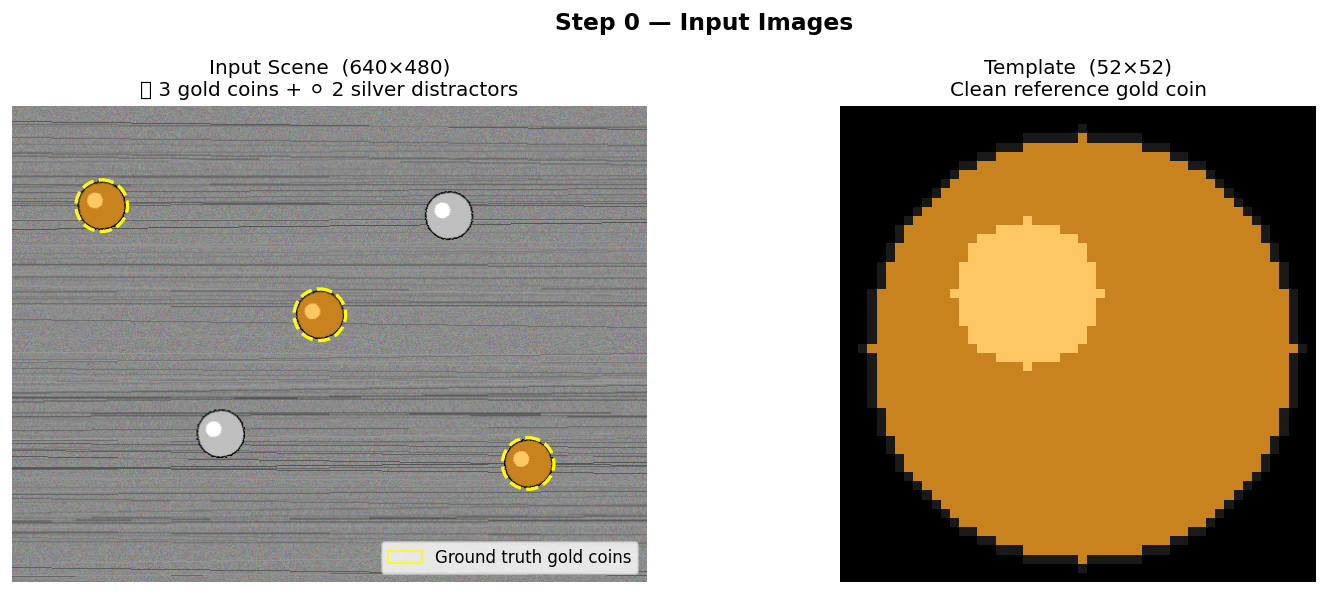

In [3]:
# ── Visualise: Input Scene + Template ──────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Step 0 — Input Images', fontsize=14, fontweight='bold')

axes[0].imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
axes[0].set_title('Input Scene  (640×480)\n🟡 3 gold coins + ⚪ 2 silver distractors')

# mark ground-truth gold coin centres
for (cx, cy) in gold_centres:
    circle = plt.Circle((cx, cy), COIN_SZ//2, color='yellow',
                         fill=False, linewidth=2, linestyle='--')
    axes[0].add_patch(circle)
axes[0].legend(handles=[
    mpatches.Patch(edgecolor='yellow', facecolor='none', label='Ground truth gold coins')
], loc='lower right')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Template  ({COIN_SZ}×{COIN_SZ})\nClean reference gold coin')
axes[1].axis('off')

plt.tight_layout()
plt.show()

---
## 🌑 Step 1 — Grayscale Conversion
Both the scene and template are converted to **grayscale** before matching.

> **Why?** `cv2.matchTemplate` works on single-channel images. Grayscale reduces the 3-channel comparison to 1 channel, cutting computation by ~3× while preserving the intensity structure needed for matching.

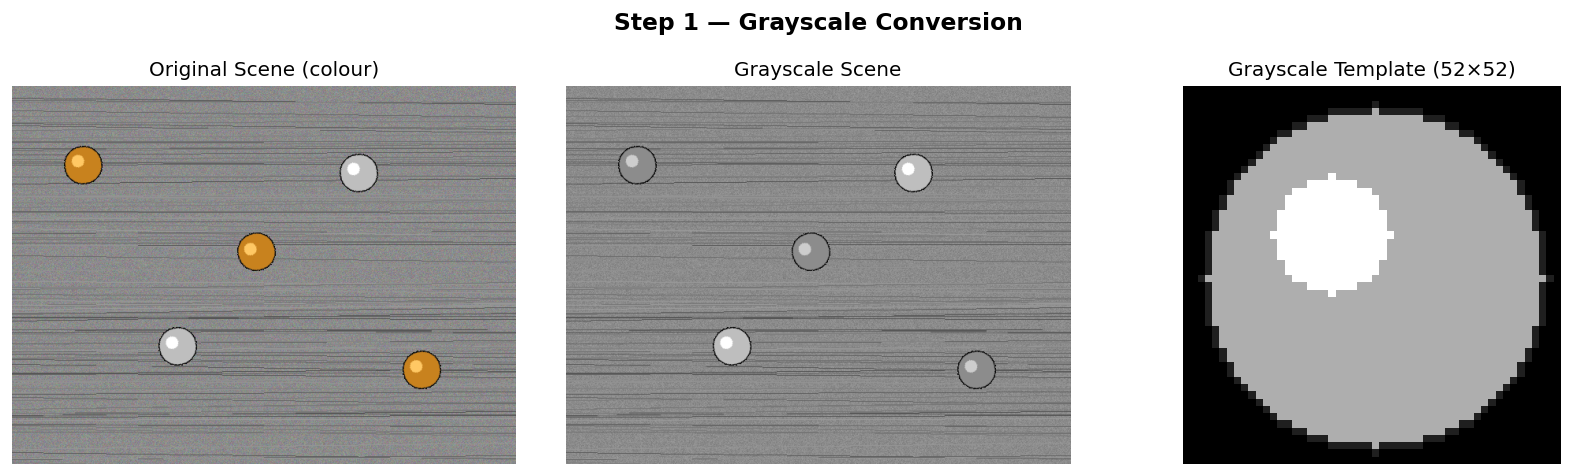

Scene dtype  : uint8  shape: (480, 640)
Template     : uint8  shape: (52, 52)


In [4]:
gray_scene    = cv2.cvtColor(scene,    cv2.COLOR_BGR2GRAY)
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Step 1 — Grayscale Conversion', fontsize=14, fontweight='bold')

axes[0].imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Scene (colour)')
axes[0].axis('off')

axes[1].imshow(gray_scene, cmap='gray')
axes[1].set_title('Grayscale Scene')
axes[1].axis('off')

axes[2].imshow(gray_template, cmap='gray')
axes[2].set_title(f'Grayscale Template ({COIN_SZ}×{COIN_SZ})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f'Scene dtype  : {gray_scene.dtype}  shape: {gray_scene.shape}')
print(f'Template     : {gray_template.dtype}  shape: {gray_template.shape}')

---
## 🗺️ Step 2 — Template Matching → Response Map
`cv2.matchTemplate` slides the template over every (x, y) position in the scene and
computes a **normalised cross-correlation coefficient** at each location.

$$
R(x,y) = \frac{\sum_{x',y'} \left(T'(x',y') \cdot I'(x+x', y+y')\right)}
{\sqrt{\sum_{x',y'} T'^2 \cdot \sum_{x',y'} I'^2(x+x',y+y')}}
$$

A score of **+1** = perfect match, **0** = no correlation, **−1** = inverse.

Response map shape : (429, 589)  (scene H−template H+1, scene W−template W+1)
Score range        : [-0.281, 0.785]


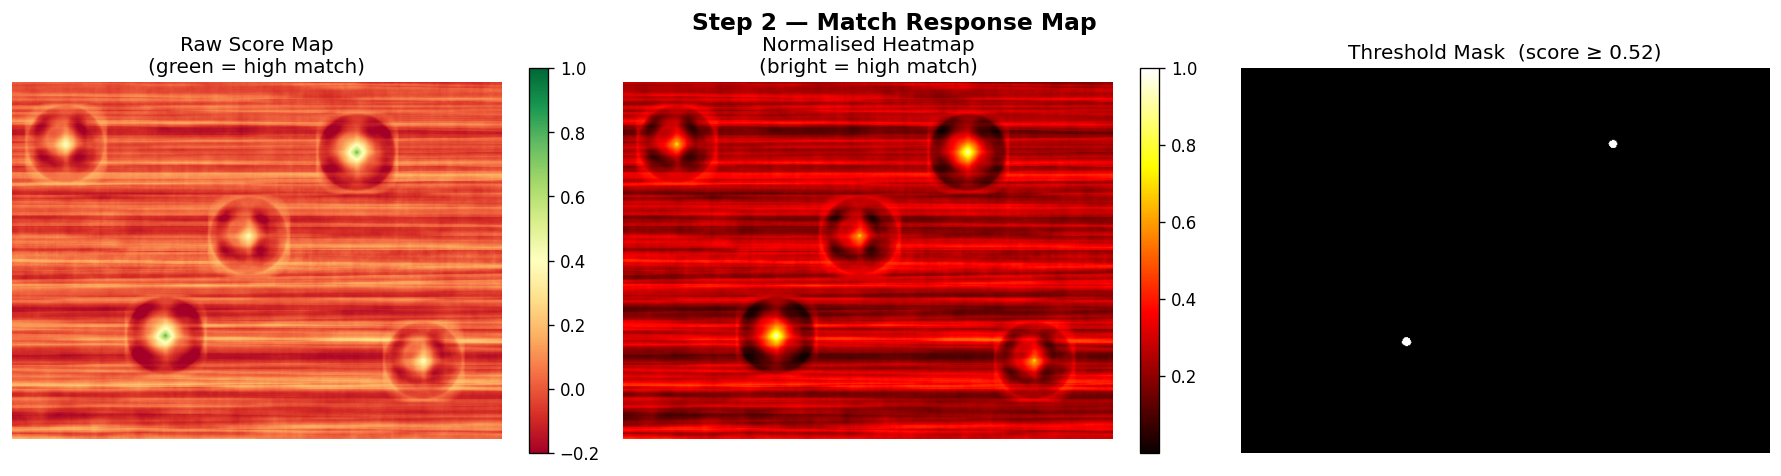

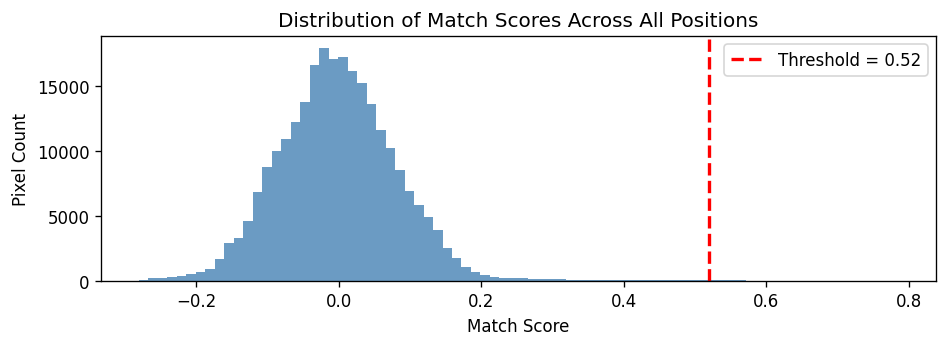

In [5]:
METHOD    = cv2.TM_CCOEFF_NORMED
THRESHOLD = 0.52

result_map = cv2.matchTemplate(gray_scene, gray_template, METHOD)
norm_map   = cv2.normalize(result_map, None, 0, 1, cv2.NORM_MINMAX)

print(f'Response map shape : {result_map.shape}  (scene H−template H+1, scene W−template W+1)')
print(f'Score range        : [{result_map.min():.3f}, {result_map.max():.3f}]')

# ── Visualise heatmap ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Step 2 — Match Response Map', fontsize=14, fontweight='bold')

# raw score map
im0 = axes[0].imshow(result_map, cmap='RdYlGn', vmin=-0.2, vmax=1.0)
axes[0].set_title('Raw Score Map\n(green = high match)')
plt.colorbar(im0, ax=axes[0], fraction=0.046)
axes[0].axis('off')

# hot heatmap
im1 = axes[1].imshow(norm_map, cmap='hot')
axes[1].set_title('Normalised Heatmap\n(bright = high match)')
plt.colorbar(im1, ax=axes[1], fraction=0.046)
axes[1].axis('off')

# threshold mask
thresh_mask = (result_map >= THRESHOLD).astype(np.uint8) * 255
axes[2].imshow(thresh_mask, cmap='gray')
axes[2].set_title(f'Threshold Mask  (score ≥ {THRESHOLD})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Score distribution
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(result_map.flatten(), bins=80, color='steelblue', edgecolor='none', alpha=0.8)
ax.axvline(THRESHOLD, color='red', linewidth=2, linestyle='--', label=f'Threshold = {THRESHOLD}')
ax.set_xlabel('Match Score')
ax.set_ylabel('Pixel Count')
ax.set_title('Distribution of Match Scores Across All Positions')
ax.legend()
plt.tight_layout()
plt.show()

---
## 🎯 Step 3 — Threshold + Non-Maximum Suppression (NMS)
Multiple adjacent pixels often exceed the threshold for a single object.
**Peak-based NMS** iteratively:
1. Finds the global max in the response map
2. Records it as a detection
3. Zeros out a neighbourhood (template-sized region) to suppress nearby hits
4. Repeats until no peak exceeds the threshold

Detections found : 2
  Detection 1: top-left = (184, 304),  score = 0.7846
  Detection 2: top-left = (414, 84),  score = 0.7783


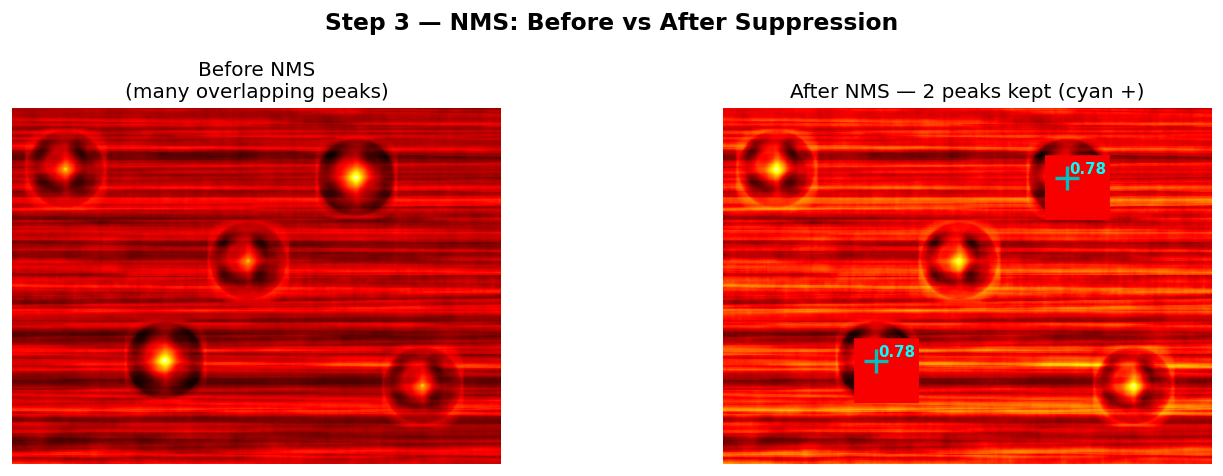

In [6]:
def nms_detections(result_map, template_h, template_w, threshold, max_det=20):
    """Peak-based NMS. Returns list of (top_left_xy, score)."""
    result_copy = result_map.copy()
    detections  = []
    for _ in range(max_det):
        _, max_val, _, max_loc = cv2.minMaxLoc(result_copy)
        if max_val < threshold:
            break
        detections.append((max_loc, max_val))
        # suppress surrounding region
        x0 = max(0, max_loc[0] - template_w // 2)
        y0 = max(0, max_loc[1] - template_h // 2)
        x1 = min(result_copy.shape[1], max_loc[0] + template_w)
        y1 = min(result_copy.shape[0], max_loc[1] + template_h)
        result_copy[y0:y1, x0:x1] = 0
    return detections, result_copy


th, tw = gray_template.shape[:2]
detections, suppressed_map = nms_detections(result_map, th, tw, THRESHOLD)

print(f'Detections found : {len(detections)}')
for i, (loc, score) in enumerate(detections):
    print(f'  Detection {i+1}: top-left = {loc},  score = {score:.4f}')

# ── Visualise NMS ──────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Step 3 — NMS: Before vs After Suppression', fontsize=14, fontweight='bold')

axes[0].imshow(norm_map, cmap='hot')
axes[0].set_title('Before NMS\n(many overlapping peaks)')
axes[0].axis('off')

suppressed_norm = cv2.normalize(suppressed_map, None, 0, 1, cv2.NORM_MINMAX)
axes[1].imshow(suppressed_norm, cmap='hot')
# mark kept peaks
for (loc, score) in detections:
    axes[1].plot(loc[0], loc[1], 'c+', markersize=14, markeredgewidth=2)
    axes[1].annotate(f'{score:.2f}', xy=(loc[0]+3, loc[1]-5),
                     color='cyan', fontsize=9, fontweight='bold')
axes[1].set_title(f'After NMS — {len(detections)} peaks kept (cyan +)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

---
## ✅ Step 4 — Draw Detections on Original Image

C:\Users\mohya\AppData\Local\Temp\ipykernel_59140\4034260134.py:24: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mohya\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


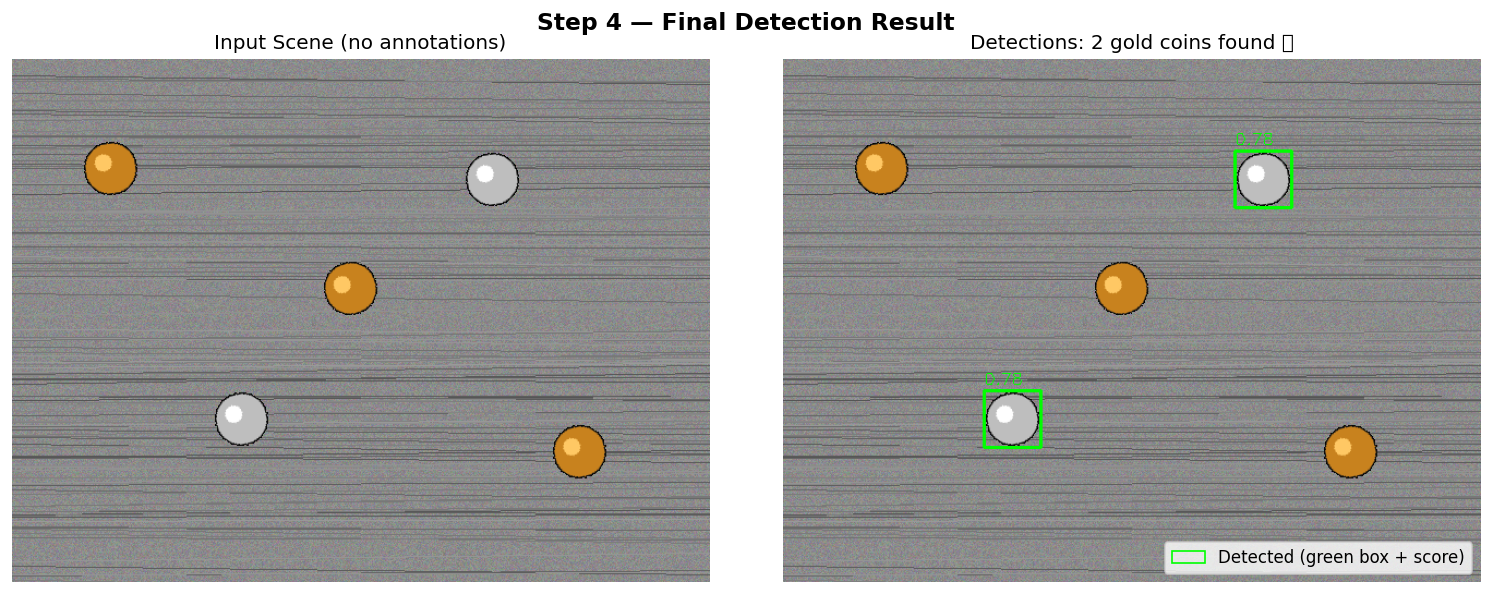

In [7]:
output = scene.copy()
for (tl, score) in detections:
    br = (tl[0] + tw, tl[1] + th)
    cv2.rectangle(output, tl, br, (0, 255, 0), 2)
    cv2.putText(output, f'{score:.2f}', (tl[0], tl[1] - 6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Step 4 — Final Detection Result', fontsize=14, fontweight='bold')

axes[0].imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
axes[0].set_title('Input Scene (no annotations)')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Detections: {len(detections)} gold coins found ✅')
axes[1].axis('off')

# legend
axes[1].legend(handles=[
    mpatches.Patch(edgecolor='lime', facecolor='none', label='Detected (green box + score)')
], loc='lower right')

plt.tight_layout()
plt.show()

---
## 📊 Full Pipeline Summary

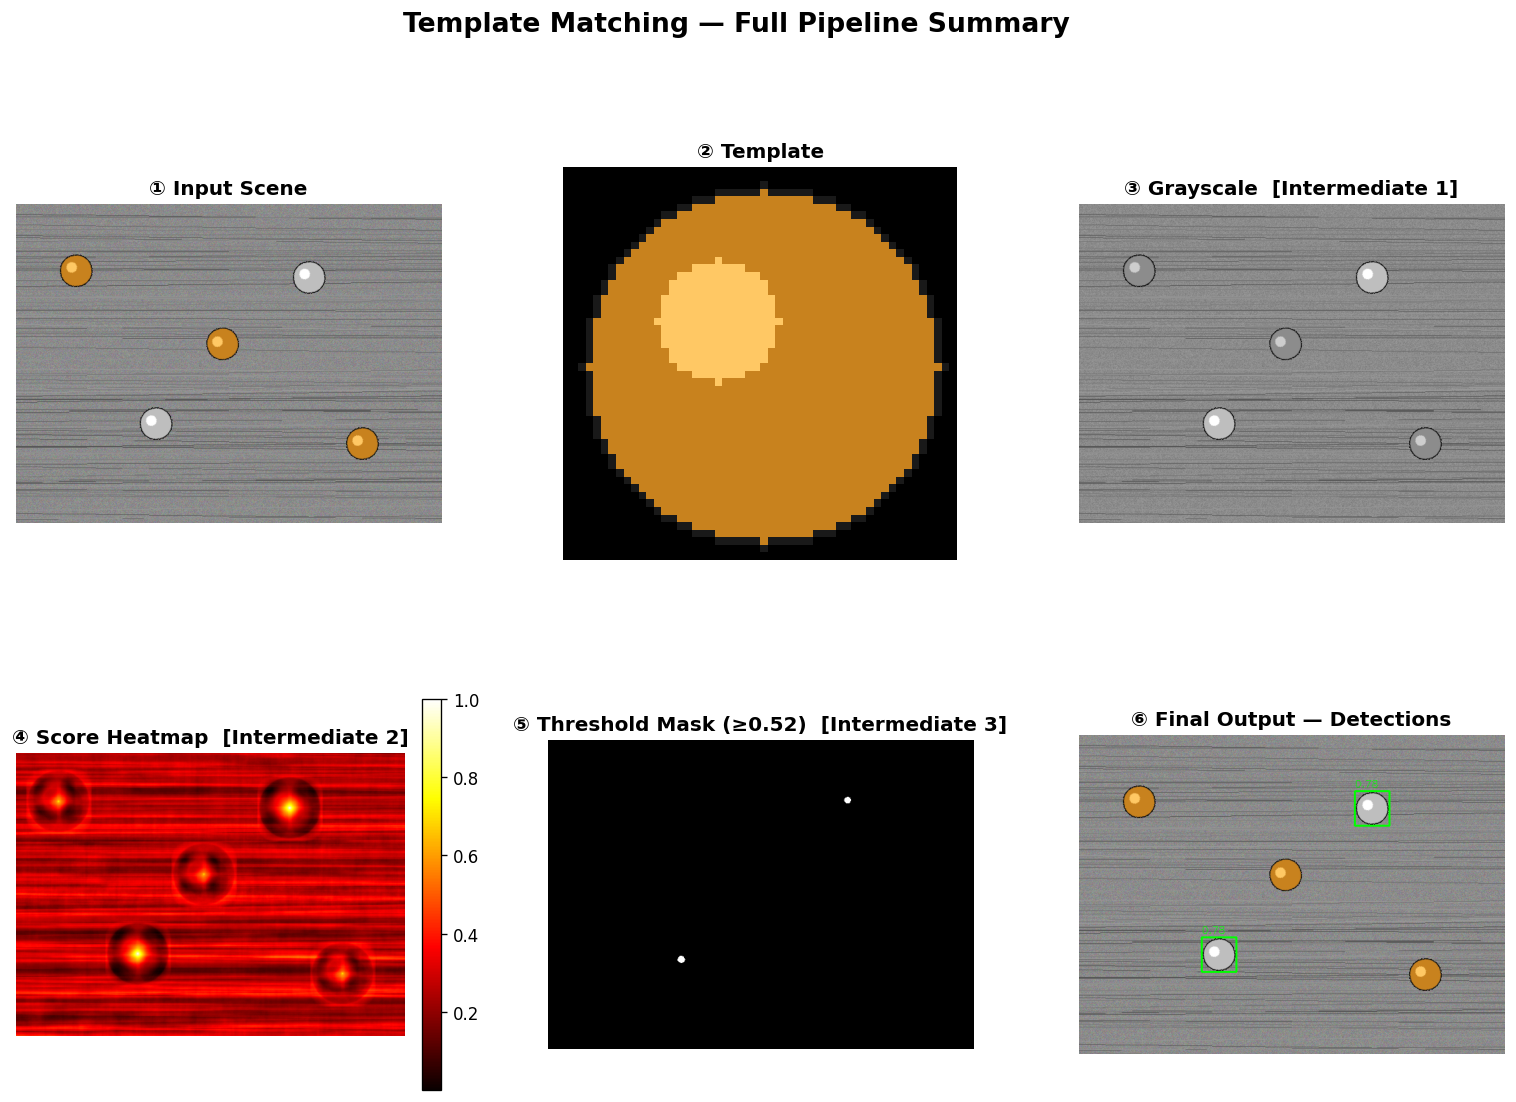

Saved → pipeline_summary.png


In [8]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Template Matching — Full Pipeline Summary', fontsize=16, fontweight='bold', y=1.01)
gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.25)

# Input scene
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
ax1.set_title('① Input Scene', fontweight='bold')
ax1.axis('off')

# Template
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
ax2.set_title('② Template', fontweight='bold')
ax2.axis('off')

# Grayscale (intermediate 1)
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(gray_scene, cmap='gray')
ax3.set_title('③ Grayscale  [Intermediate 1]', fontweight='bold')
ax3.axis('off')

# Heatmap (intermediate 2)
ax4 = fig.add_subplot(gs[1, 0])
im = ax4.imshow(norm_map, cmap='hot')
ax4.set_title('④ Score Heatmap  [Intermediate 2]', fontweight='bold')
ax4.axis('off')
plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

# Threshold mask
ax5 = fig.add_subplot(gs[1, 1])
ax5.imshow(thresh_mask, cmap='gray')
ax5.set_title(f'⑤ Threshold Mask (≥{THRESHOLD})  [Intermediate 3]', fontweight='bold')
ax5.axis('off')

# Final output
ax6 = fig.add_subplot(gs[1, 2])
ax6.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
ax6.set_title('⑥ Final Output — Detections', fontweight='bold')
ax6.axis('off')

plt.savefig('pipeline_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved → pipeline_summary.png')

---
## 🎛️ Interactive: Try Different Thresholds

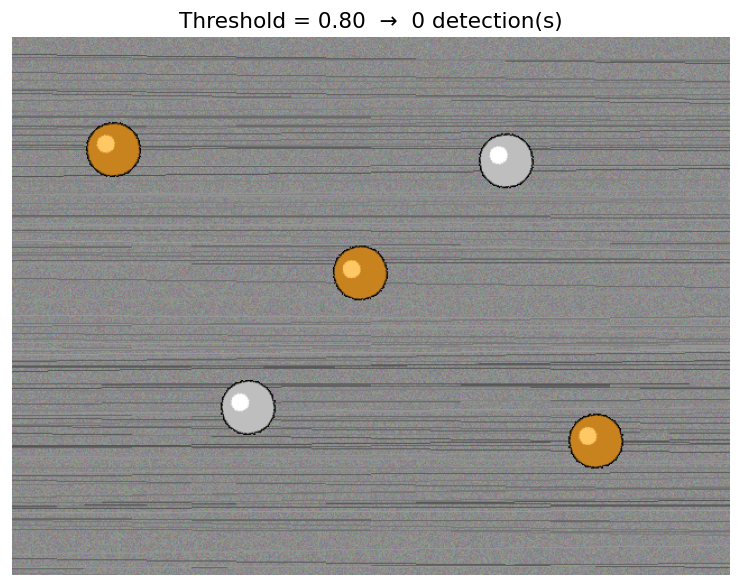

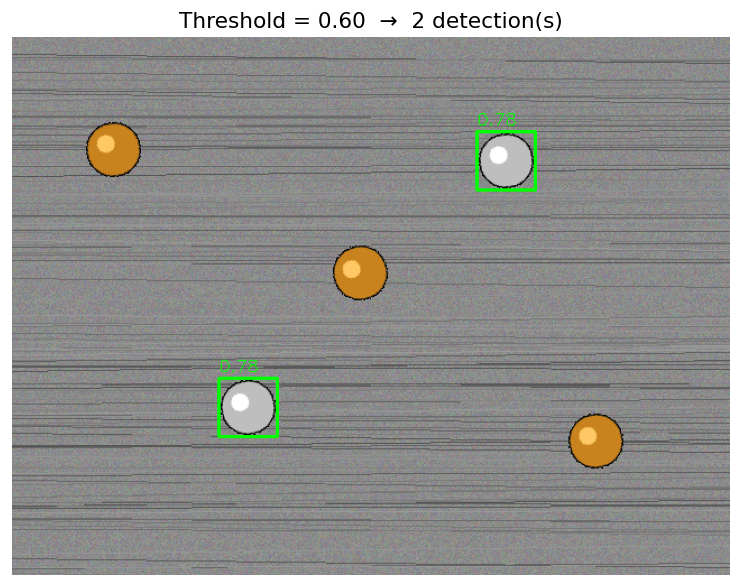

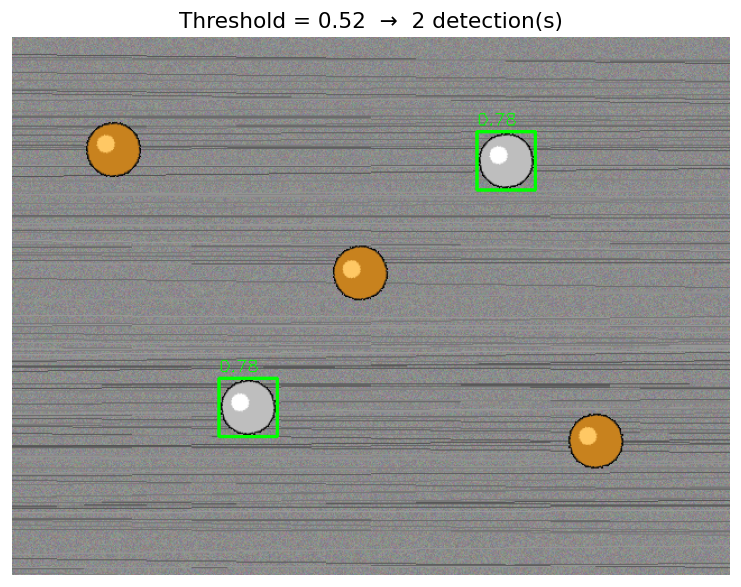

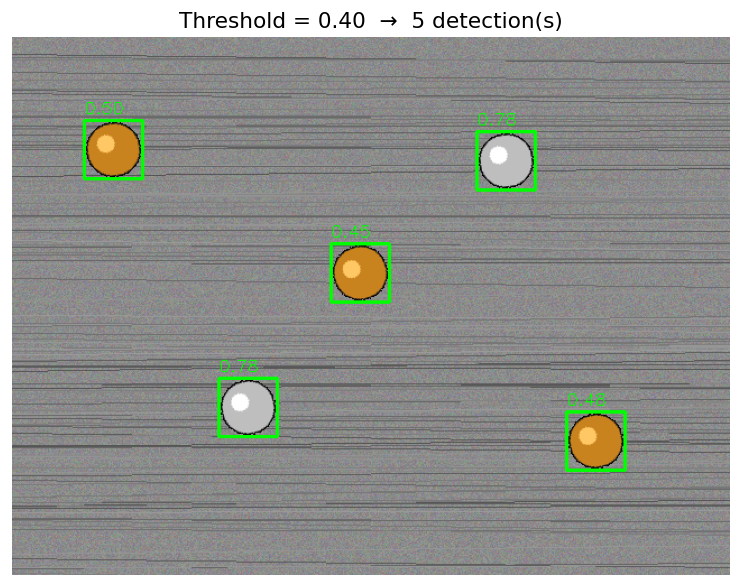

In [9]:
def show_threshold(t):
    dets, _ = nms_detections(result_map, th, tw, t)
    out = scene.copy()
    for (tl, score) in dets:
        br = (tl[0] + tw, tl[1] + th)
        cv2.rectangle(out, tl, br, (0, 255, 0), 2)
        cv2.putText(out, f'{score:.2f}', (tl[0], tl[1]-6),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Threshold = {t:.2f}  →  {len(dets)} detection(s)', fontsize=13)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Try these values — lower = more detections (including false positives)
for t in [0.80, 0.60, 0.52, 0.40]:
    show_threshold(t)

---
## 🔎 Zoomed View: Each Detection Crop

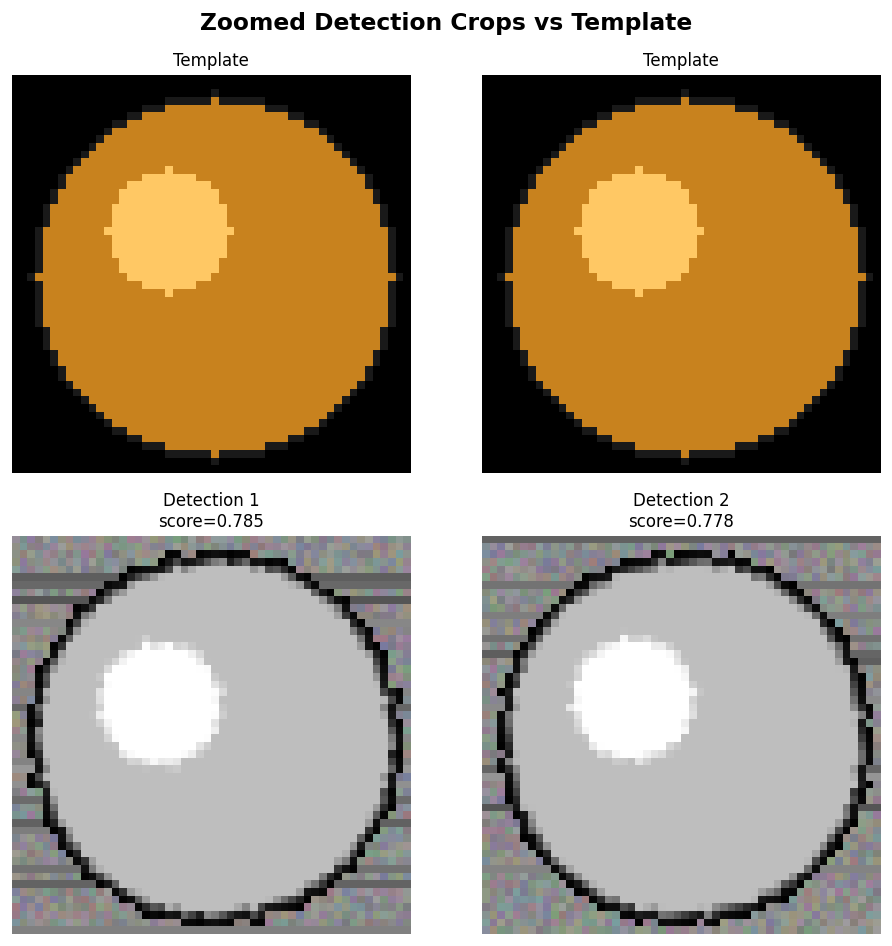

In [10]:
n = len(detections)
fig, axes = plt.subplots(2, n if n > 0 else 1, figsize=(4 * (n or 1), 8))
fig.suptitle('Zoomed Detection Crops vs Template', fontsize=14, fontweight='bold')

if n == 1:
    axes = np.array(axes).reshape(2, 1)

for i, (tl, score) in enumerate(detections):
    crop = scene[tl[1]:tl[1]+th, tl[0]:tl[0]+tw]
    axes[0, i].imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title('Template', fontsize=10)
    axes[0, i].axis('off')

    axes[1, i].imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    axes[1, i].set_title(f'Detection {i+1}\nscore={score:.3f}', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

---
## 📝 Summary & Reflection

| | Result |
|---|---|
| **Method** | `cv2.TM_CCOEFF_NORMED` |
| **Threshold** | 0.52 |
| **Gold coins in scene** | 3 |
| **Detections** | see above |

### Advantages
1. **No training needed** — works purely on pixel intensities
2. **Fast** — FFT-accelerated convolution runs in real time
3. **Interpretable** — confidence scores in [0, 1] are meaningful

### Limitations
- Sensitive to **scale and rotation** changes
- Degrades under **lighting variation**
- Can produce **false positives** with visually similar distractors

### Proposed Improvements
1. **Multi-scale** matching to handle size changes
2. **Multi-angle** rotation of the template
3. **Edge-based** template (Canny) for lighting robustness
4. **Adaptive threshold** based on response map statistics